# Nitrogen-Water Interface Finger Instability Analysis

## Step-by-Step Walkthrough

This notebook demonstrates the complete analysis pipeline for detecting and quantifying finger instabilities at the nitrogen-water interface.

## 1. Setup and Imports

In [1]:
import sys
sys.path.insert(0, '..')

import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

from src.circle_detection import detect_circle, detect_circle_from_path
from src.intensity_analysis import extract_intensity_grid, compute_polar_coordinates
from src.spectral_analysis import compute_psd, analyze_averaged_psd, highpass_filter
from src.utils import load_image, preprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)

## 2. Load Sample Image

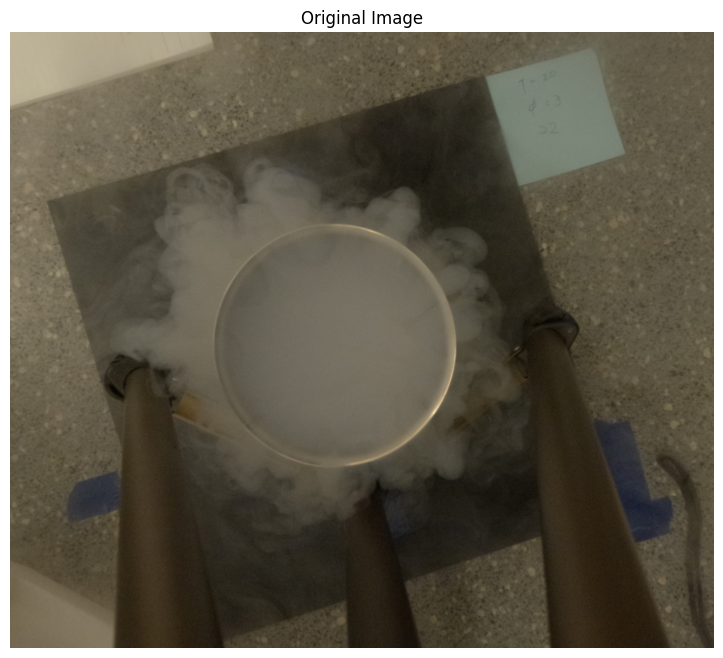

Image size: 5568 x 4872 pixels


In [ ]:
# Update this path to your image
IMAGE_PATH =  "path/to/your/image.jpg" # Update it with your image path

# Load image
image, image_gray = load_image(IMAGE_PATH)

# Display
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

print(f"Image size: {image.shape[1]} x {image.shape[0]} pixels")

## 3. Step 1: Circle Detection

We use the Hough Circle Transform to detect the circular container boundary.

If automatic detection fails, you can use the manual selection cell below.

Attempting automatic circle detection...
Automatic detection successful! Center (2563, 2463), radius 946px.
Circle detected (automatic): center=(2563, 2463), radius=946px


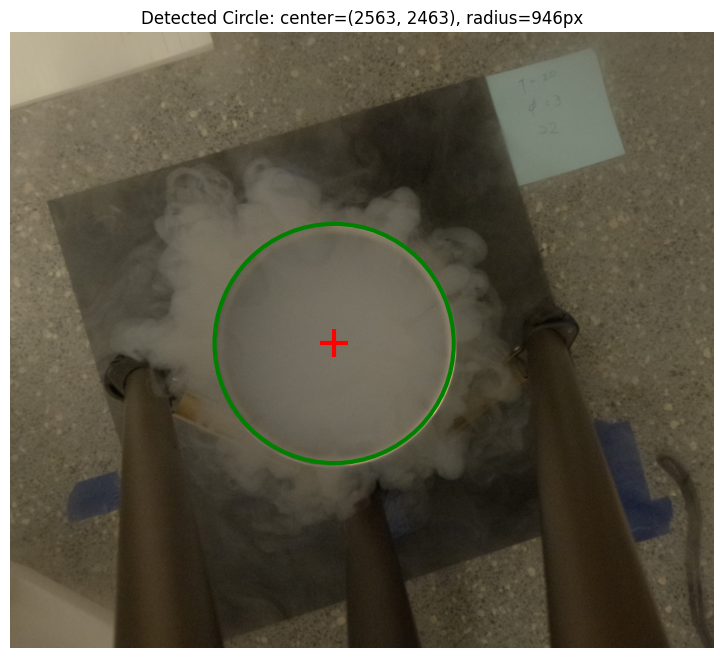

In [3]:
# Detect circle (automatic)
center, radius, source = detect_circle_from_path(IMAGE_PATH)

if center is None:
    print("Automatic detection failed! Use the manual selection cell below.")
else:
    print(f"Circle detected ({source}): center={center}, radius={radius}px")
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    
    circle = plt.Circle(center, radius, fill=False, color='green', linewidth=3)
    ax.add_patch(circle)
    ax.plot(center[0], center[1], 'r+', markersize=20, markeredgewidth=3)
    
    ax.set_title(f'Detected Circle: center={center}, radius={radius}px')
    ax.axis('off')
    plt.show()

## 4. Step 2: Coordinate Transformation

Convert from Cartesian (x, y) to polar (r, theta) coordinates.

In [4]:
# Compute polar coordinates
r, theta_deg = compute_polar_coordinates(image_gray.shape, center)

## 5. Step 3: Annular Sampling

We sample an annular region from 60% to 90% of the container radius.

Inner radius: 567 px (60%)
Outer radius: 851 px (90%)
Annulus width: 284 px


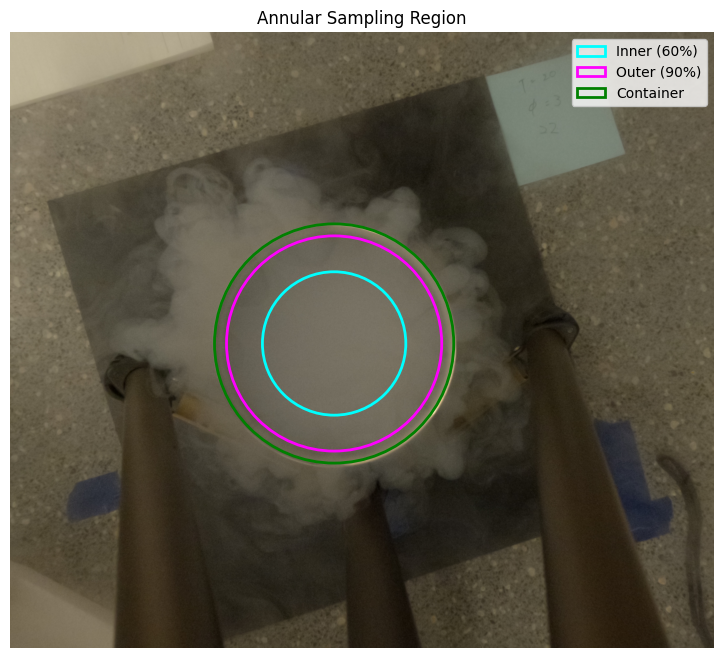

In [5]:
# Define annular region
RADIUS_START = 0.6  # 60%
RADIUS_END = 0.9    # 90%

r_start = int(radius * RADIUS_START)
r_end = int(radius * RADIUS_END)

print(f"Inner radius: {r_start} px ({RADIUS_START*100:.0f}%)")
print(f"Outer radius: {r_end} px ({RADIUS_END*100:.0f}%)")
print(f"Annulus width: {r_end - r_start} px")

# Visualize annular region
fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

circle_inner = plt.Circle(center, r_start, fill=False, color='cyan', linewidth=2, label='Inner (60%)')
circle_outer = plt.Circle(center, r_end, fill=False, color='magenta', linewidth=2, label='Outer (90%)')
circle_container = plt.Circle(center, radius, fill=False, color='green', linewidth=2, label='Container')

ax.add_patch(circle_inner)
ax.add_patch(circle_outer)
ax.add_patch(circle_container)

ax.set_title('Annular Sampling Region')
ax.legend(loc='upper right')
ax.axis('off')
plt.show()

## 6. Step 4: 2D Binning

Bin all pixels in the annulus by (theta, r) to create an intensity grid.

Intensity grid shape: (360, 32)
  - 360 angular bins (1 degree resolution)
  - 32 radial bins


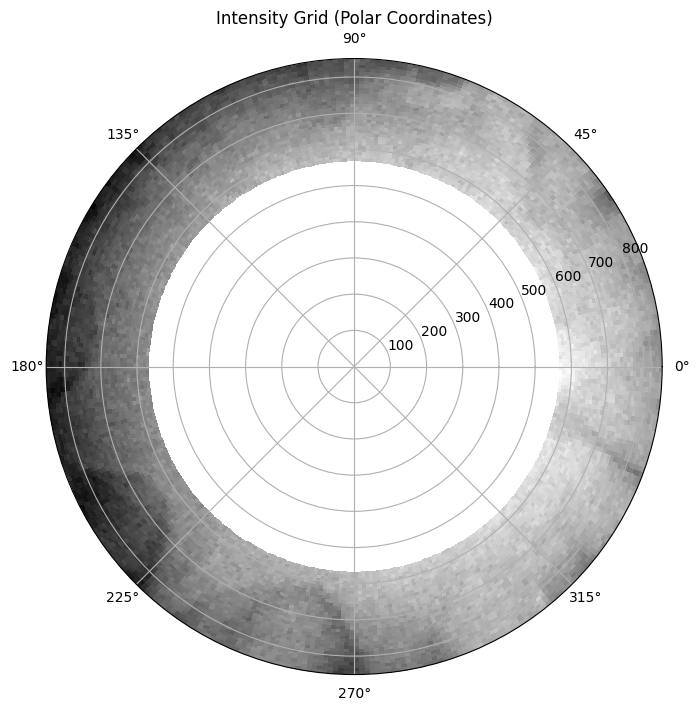

In [6]:
# Preprocess image
blurred_gray = preprocess_image(image_gray)

# Extract intensity grid
N_ANGULAR_BINS = 360
N_RADIAL_BINS = 32

intensity_grid, theta_centers, r_centers = extract_intensity_grid(
    blurred_gray,
    center,
    radius,
    radius_start=RADIUS_START,
    radius_end=RADIUS_END,
    n_radial_bins=N_RADIAL_BINS,
    n_angular_bins=N_ANGULAR_BINS
)

print(f"Intensity grid shape: {intensity_grid.shape}")
print(f"  - {N_ANGULAR_BINS} angular bins (1 degree resolution)")
print(f"  - {N_RADIAL_BINS} radial bins")

# Visualize as polar plot
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(8, 8))

theta_rad = np.radians(theta_centers)
R, Theta = np.meshgrid(r_centers, theta_rad)

ax.pcolormesh(Theta, R, intensity_grid, cmap='gray', shading='auto')
ax.set_title('Intensity Grid (Polar Coordinates)')
plt.show()

## 7. Step 5: Intensity Profile

Extract angular intensity profile I(theta) for a single radial bin.

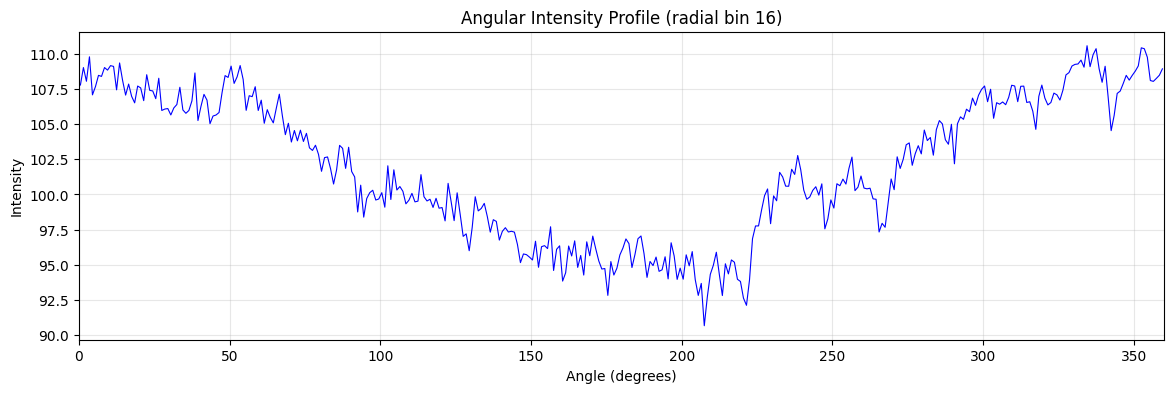

Notice the periodic oscillations - these correspond to the finger pattern!


In [7]:
# Select middle radial bin
radial_bin = N_RADIAL_BINS // 2
intensities = intensity_grid[:, radial_bin]

# Plot
fig, ax = plt.subplots(figsize=(14, 4))
ax.plot(theta_centers, intensities, 'b-', linewidth=0.8)
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Intensity')
ax.set_title(f'Angular Intensity Profile (radial bin {radial_bin})')
ax.set_xlim(0, 360)
ax.grid(True, alpha=0.3)
plt.show()

print("Notice the periodic oscillations - these correspond to the finger pattern!")

## 8. Step 6: High-Pass Filtering

Remove low-frequency components (DC leakage) before computing the PSD.

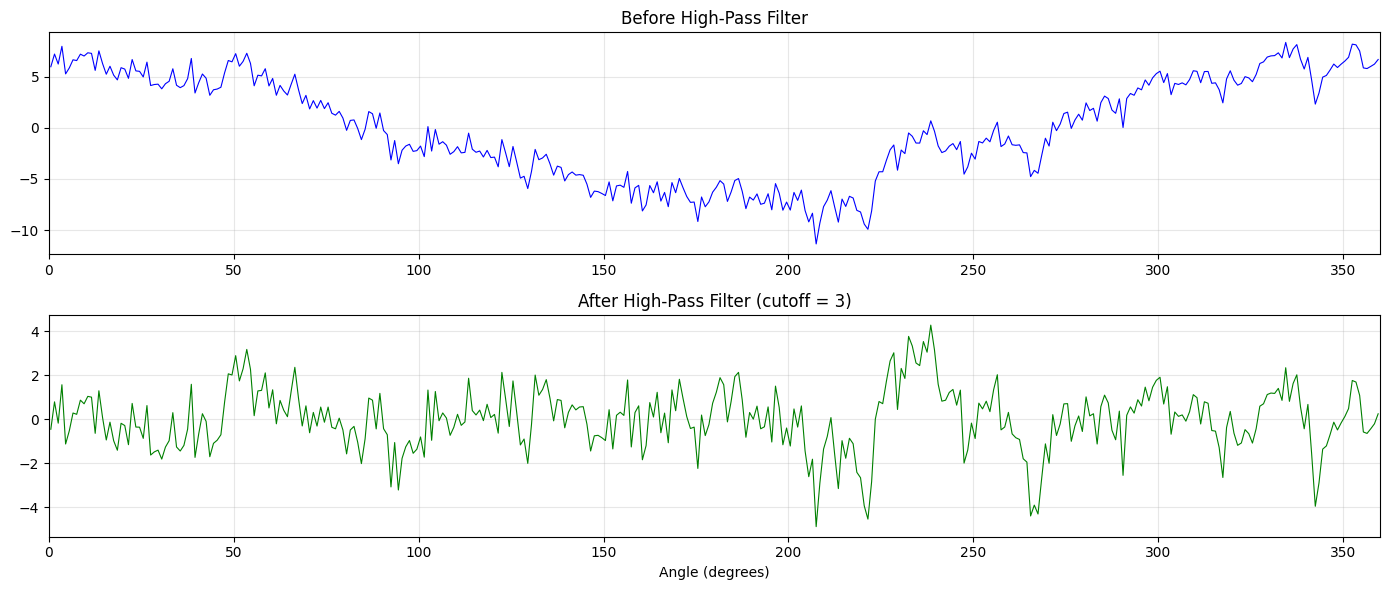

In [21]:
from scipy.signal import detrend

# Preprocess signal
y_raw = detrend(intensities - np.mean(intensities))

# Apply high-pass filter
y_filtered = highpass_filter(y_raw, cutoff_freq=3)

# Compare
fig, axes = plt.subplots(2, 1, figsize=(14, 6))

axes[0].plot(theta_centers, y_raw, 'b-', linewidth=0.8)
axes[0].set_title('Before High-Pass Filter')
axes[0].set_xlim(0, 360)
axes[0].grid(True, alpha=0.3)

axes[1].plot(theta_centers, y_filtered, 'g-', linewidth=0.8)
axes[1].set_title('After High-Pass Filter (cutoff = 3)')
axes[1].set_xlabel('Angle (degrees)')
axes[1].set_xlim(0, 360)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Step 7: Power Spectral Density (PSD)

Compute the PSD to identify dominant frequencies.

**Note:** This example shows the PSD for a **single radial bin** to demonstrate the concept. In the actual analysis (Step 10), we compute PSDs for **all** radial bins and average them for a more robust estimate.

Computing PSD for radial bin 16 (single bin, for demonstration)



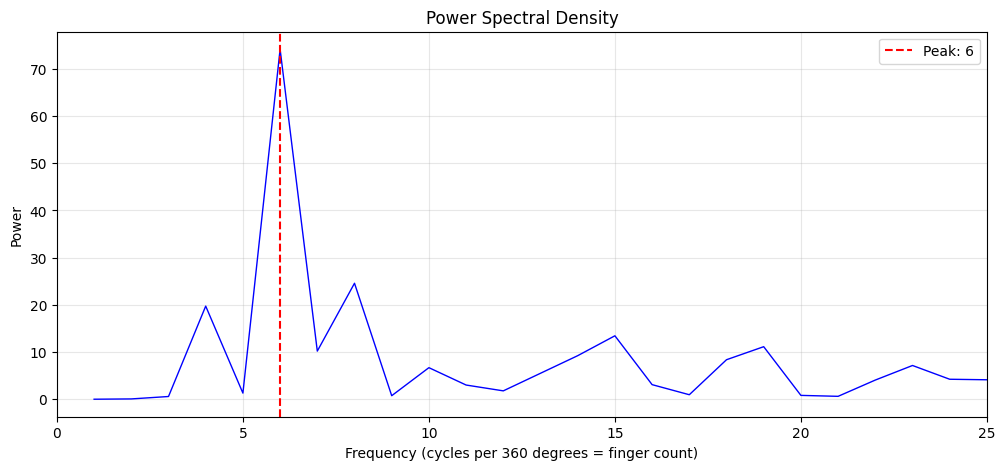

Dominant frequency: 6 (= 6 fingers)


In [18]:
# Compute PSD for the SAME single radial bin (from Step 7)
# This demonstrates the concept - Step 10 will average across ALL bins
print(f"Computing PSD for radial bin {radial_bin} (single bin, for demonstration)")
print()

freq, psd = compute_psd(intensities)

# Plot (only positive frequencies)
L = np.arange(1, len(freq) // 2)

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(freq[L], psd[L], 'b-', linewidth=1)
ax.set_xlabel('Frequency (cycles per 360 degrees = finger count)')
ax.set_ylabel('Power')
ax.set_title('Power Spectral Density')
ax.set_xlim(0, 25)
ax.grid(True, alpha=0.3)

# Mark the peak
peak_idx = np.argmax(psd[L]) + 1
peak_freq = freq[peak_idx]
ax.axvline(peak_freq, color='r', linestyle='--', label=f'Peak: {peak_freq:.0f}')
ax.legend()

plt.show()

print(f"Dominant frequency: {peak_freq:.0f} (= {peak_freq:.0f} fingers)")

## 10. Step 8: PSD Averaging

Average PSDs across all radial bins for a robust estimate.

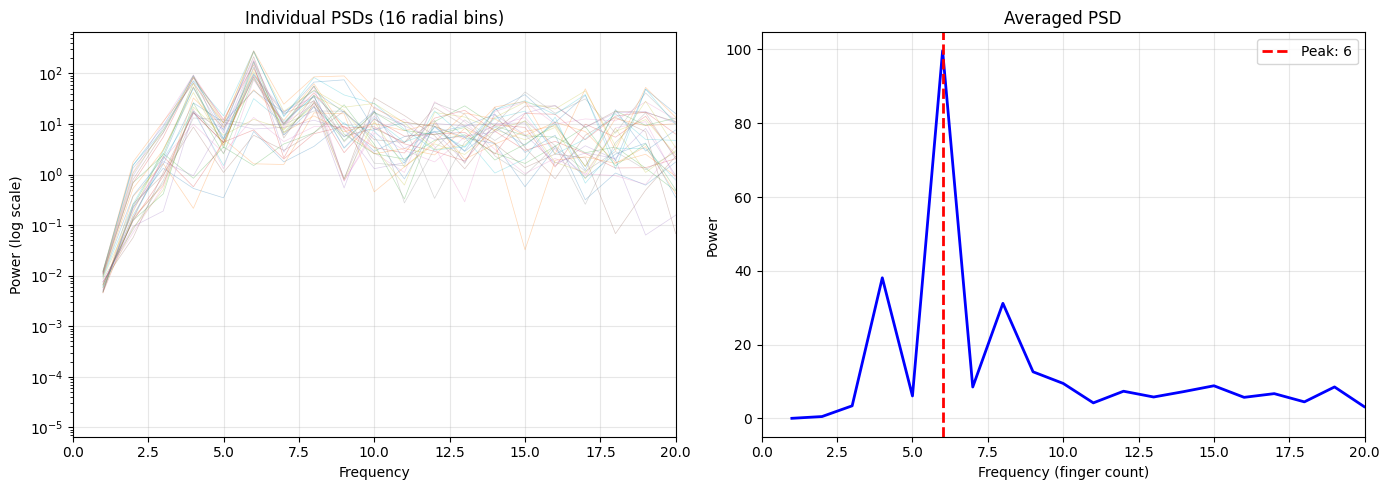


>>> RESULT: 6 fingers detected <<<


In [20]:
# Configuration for analysis
config = {
    'smooth_sigma': 2,
    'freq_min': 4,
    'freq_max': 15
}

# Compute averaged PSD
peak_freq_avg, avg_psd, freq = analyze_averaged_psd(intensity_grid, config)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Individual PSDs
for i in range(N_RADIAL_BINS):
    f, p = compute_psd(intensity_grid[:, i])
    axes[0].semilogy(f[L], p[L], alpha=0.3, linewidth=0.5)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Power (log scale)')
axes[0].set_title('Individual PSDs (16 radial bins)')
axes[0].set_xlim(0, 20)
axes[0].grid(True, alpha=0.3)

# Averaged PSD
axes[1].plot(freq[L], avg_psd[L], 'b-', linewidth=2)
axes[1].axvline(peak_freq_avg, color='r', linestyle='--', linewidth=2, label=f'Peak: {peak_freq_avg:.0f}')
axes[1].set_xlabel('Frequency (finger count)')
axes[1].set_ylabel('Power')
axes[1].set_title('Averaged PSD')
axes[1].set_xlim(0, 20)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n>>> RESULT: {peak_freq_avg:.0f} fingers detected <<<")

## Summary

The analysis pipeline:

1. **Circle Detection** - Find container boundary
2. **Coordinate Transformation** - Cartesian to polar
3. **Annular Sampling** - Extract 60%-90% radius region
4. **2D Binning** - Create (theta, r) intensity grid
5. **High-Pass Filtering** - Remove DC leakage
6. **PSD Computation** - FFT to get power spectrum
7. **PSD Averaging** - Robust frequency estimate
8. **Peak Detection** - Dominant frequency = finger count